>
> # H3 tutorial
> ##### farnoud.ghasemi@doctoral.uj.edu.pl
-----
* You can read about H3 package here: https://www.uber.com/en-PL/blog/h3/
* And access the main code on github here: https://github.com/uber/h3
-----

In [17]:
# First import H3 and other required packages

import h3
import folium
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
import random
import pandas as pd
import numpy as np
import seaborn as sns
import json
from geojson.feature import Feature, FeatureCollection
from osmnx.distance import get_nearest_node

In [18]:
# H3 assigns an specific address to each point on the map. To do so, H3 needs longitude and
# latitude of each point. Each address specifies a hexagon.

lat = 37.769377
lng = -122.388903
zoning_level = 8
h3_address = h3.geo_to_h3(lat, lng, zoning_level)
h3_address

'88283082e7fffff'

In [19]:
# Here are some visualization functions.

def visualize_hexagons(hexagons, color="red", w=1, folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=w,color=color,fill= True)
        m.add_child(my_PolyLine)
    return m
    

def visualize_polygon(polyline, color):
    polyline.append(polyline[0])
    lat = [p[0] for p in polyline]
    lng = [p[1] for p in polyline]
    m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
    m.add_child(my_PolyLine)
    return m

In [20]:
# visualize a hexagon with its address
hexagons = ['88283082e7fffff']
visualize_hexagons(hexagons, color="red", w=1, folium_map=None)

In [21]:
# Change the level of zoning to modify the size of hexagons - 1 is the largest and 9 is the 
# smallest

lat = 37.769377
lng = -122.388903
zoning_level = 2
h3_address = h3.geo_to_h3(lat, lng, zoning_level)
hexagons = [h3_address]
visualize_hexagons(hexagons, color="blue", w=1, folium_map=None)
# zoom out to see the hexagon

In [22]:
# You can do the reverse and get the longitude and latitude for each hexagon which are 
# indicationg the center of hexagon.

hex_center_coordinates = h3.h3_to_geo(h3_address)
hex_center_coordinates

(38.19320895493078, -122.19619675659699)

In [23]:
# the geospatial data like graphs we use in MaaSSim and ExMAS is generated by OSMnx package.

paths= "Delft.graphml"  
G = ox.load_graphml(paths) # this is the graph

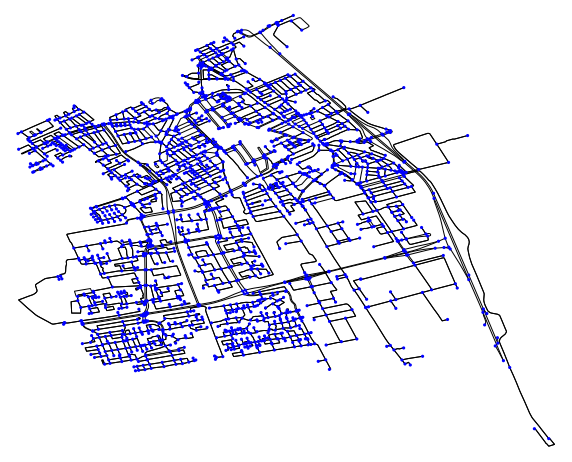

In [24]:
# You can plot the graph which is a set of nodes and edges.

fig, ax = ox.plot_graph(G, figsize=(10, 10), show=False, close=False, node_size=10, bgcolor='white',
                        node_color='blue', edge_color='black')

In [26]:
# Graph nodes are used to specify origins and destinations.
# Here you have the all nodes for the Delf city Graph

G.nodes 

NodeView((1501364225, 1269112834, 44875780, 44875781, 1516978187, 100302898, 44818482, 44711989, 44818486, 44711991, 44777528, 4261101624, 44818490, 5715066940, 44711996, 1830076498, 44843105, 44843109, 1830076518, 44843110, 1830076520, 1830076522, 44769389, 44843122, 44720245, 44810363, 3119210620, 3119210619, 44720254, 44720256, 4502921354, 4502921355, 1965457550, 1965457552, 44884118, 44884119, 44884122, 44834972, 313319585, 3669180584, 3669180587, 44794038, 3669180600, 3669180601, 3669180604, 44859593, 44859599, 44859610, 4124549371, 4124549374, 4176994572, 4176994573, 44892459, 44867887, 44736833, 44908875, 44736847, 44818813, 44851588, 44802443, 385474972, 4968645027, 4968645028, 44835248, 44827059, 44827063, 1448509882, 44876219, 4655063484, 44876218, 44835261, 44827071, 44876223, 44835264, 44835265, 44835279, 44835282, 44777950, 2166211039, 44892653, 2860384766, 44818949, 44818951, 44884491, 44884493, 1576632846, 1576632851, 44900908, 1584013869, 44720695, 486605367, 390922807,

In [27]:
# Each node is identified by an address. Get the longitude and latitude of any node as 
# follows:

G.nodes[1501364225]

{'y': 52.0275607, 'x': 4.362211, 'osmid': 1501364225}

In [28]:
# Since you have the longitude and latitude for each node, you can use H3 for visualization.

lat = 52.0275607 
lng = 4.362211
zoning_level = 7
h3_address = h3.geo_to_h3(lat, lng, zoning_level)
hexagons = [h3_address]
visualize_hexagons(hexagons, color="blue", w=1, folium_map=None)

In [29]:
# You can apply the h3 on the whole city. But first you need to assign a hexagon for each node.

df = pd.DataFrame(columns=['node_address', 'latitude', 'longitude', 'h3_address'])
df.node_address = list(G.nodes)
df.latitude = df.apply(lambda row: G.nodes[row.node_address]['y'], axis=1)
df.longitude = df.apply(lambda row: G.nodes[row.node_address]['x'], axis=1)

zoning_level = 7
df.h3_address = df.apply(lambda row: h3.geo_to_h3(row.latitude, row.longitude, zoning_level), axis=1)

df

,node_address,latitude,longitude,h3_address
0,1501364225,52.027561,4.362211,87196bb16ffffff
1,1269112834,51.996434,4.350159,87196bb13ffffff
2,44875780,52.017872,4.355636,87196bb10ffffff
3,44875781,52.017860,4.358971,87196bb10ffffff
4,1516978187,51.991344,4.332150,87196bbacffffff
...,...,...,...,...
2151,44867552,52.015772,4.370087,87196bb10ffffff
2152,1516978145,51.990950,4.332327,87196bbacffffff
2153,549920740,52.007428,4.379520,87196bb10ffffff
2154,1501364218,52.026956,4.361468,87196bb16ffffff


In [30]:
# Some hexagons are repeated because more than one node is assigned to them. So, we just take
# the unique values.

hexagons = df.h3_address.unique()
print(hexagons)
visualize_hexagons(hexagons, color="blue", w=1, folium_map=None)

['87196bb16ffffff' '87196bb13ffffff' '87196bb10ffffff' '87196bbacffffff'
 '87196bb12ffffff' '87196bb1effffff' '87196bbadffffff' '87196bb11ffffff'
 '87196bb18ffffff' '87196bb1cffffff' '87196bb15ffffff']


In [31]:
# Now let's assign a value for each hexagon and visualize it.
# Here simply we want to visualize the number of graph nodes in the hexagons.
# First we need to know the number of nodes in each hexagon. So, we make a DataFrame.

df1 = pd.DataFrame(columns=['hex_address', 'number_of_nodes'])
df1.hex_address = df.h3_address.unique()
df1.number_of_nodes = df1.apply(lambda row: df.h3_address.value_counts()[row.hex_address], axis=1)

df1

,hex_address,number_of_nodes
0,87196bb16ffffff,148
1,87196bb13ffffff,489
2,87196bb10ffffff,503
3,87196bbacffffff,83
4,87196bb12ffffff,513
5,87196bb1effffff,115
6,87196bbadffffff,191
7,87196bb11ffffff,102
8,87196bb18ffffff,2
9,87196bb1cffffff,9


In [15]:
# Now we can visualize it with h3 using the following function.

def h3_visualization(df, hex_col, value_col):
    df['lat'] = df['hex_address'].apply(lambda x: h3.h3_to_geo(x)[0])
    df['lng'] = df['hex_address'].apply(lambda x: h3.h3_to_geo(x)[1])
    # df.set_index('hex_address', inplace=True)
    df['geom'] = df.apply(lambda x: {"type": "Polygon","coordinates": [h3.h3_to_geo_boundary(h = x['hex_address'], geo_json = True)]}, axis = 1)
    list_features = []
    for i, row in df.iterrows():
            feature = Feature(geometry = row["geom"],
                              id = row[hex_col],
                              properties = {"resolution": 9})
            list_features.append(feature)
    list_features 

    feat_collection = FeatureCollection(list_features)
    geojson_hexes = json.dumps(feat_collection)
    geojson_hexes

    cx, cy = G.nodes[centeral_node]['x'], G.nodes[centeral_node]['y']
    CENTER = [cy, cx]

    tile = 'cartodbpositron'
    base_map = folium.Map(location=CENTER, zoom_start=11,tiles=tile, zoomControl =  False)
    bins = list(np.arange(0,601,100))
    # bins = [0,100,200,300,400,500, 600]

    # for colors see https://user-images.githubusercontent.com/17128994/115975254-c2031e00-a56b-11eb-8025-d82d36bfda1d.png
    color_set = ["Spectral", "RdYlGn", "PuBu", "Accent", "OrRd", "Set1", "Set2", "Set3", "BuPu", "Dark2", "RdBu", "Oranges", "BuGn", "PiYG", "YlOrBr", "YlGn", "Pastel2", "RdPu", "Greens", "PRGn", "YlGnBu", "RdYlBu", "Paired", "BrBG", "Purples", "Reds", "Pastel1", "GnBu", "Greys", "RdGy", "YlOrRd", "PuOr", "PuRd", "Blues", "PuBuGn"]
    m = folium.Choropleth(geo_data = geojson_hexes,data = df, columns = [hex_col,value_col],key_on ="feature.id",
            fill_color='Reds', control = False, bins = bins, line_weight=1, legend_name='',
            fill_opacity=0.5, line_opacity=0.2).add_to(base_map)


    # from folium.features import DivIcon
    # for i in range(1,len(df)+1):
    #     folium.Marker(
    #         (df.loc[i-1].lat,df.loc[i-1].lng),
    #         icon=folium.DivIcon(html=f"""<div style="font-family: Times New Roman; color: grey; font-size: 10pt">{i}</div>
    #     """.format(i))
    #         ).add_to(m)

    return base_map

In [16]:
center_x = pd.DataFrame((G.nodes(data='x')))[1].mean()
center_y = pd.DataFrame((G.nodes(data='y')))[1].mean()
centeral_node = get_nearest_node(G, (center_y, center_x))

h3_visualization(df1, 'hex_address', 'number_of_nodes')